# Compare analyzers on MNIST

This notebook shows how saliency maps are computed for various methods on the MNIST dataset. We will first train a simple 3-layer MLP and then apply different methods. In the end we allow for a qualitive assesment by plotting the analysis as a grid.

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb)

## Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import matplotlib.pyplot as plt

import imp
import numpy as np
import os

from functools import partial
import keras
import keras.backend as K
import keras.models
import innvestigate




# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

Using TensorFlow backend.


In [3]:
from innvestigate.analyzer import ReverseAnalyzerBase
from innvestigate.analyzer.relevance_based.relevance_analyzer import DeepTaylor


import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.keras.checks as kchecks
import innvestigate.utils.keras as kutils


import innvestigate.utils.keras.graph as kgraph



import innvestigate.layers as ilayers



## Data
Load the dataset and keep some images from the test set for the analysis.

In [4]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

## Model
The next part trains and evaluates a CNN.

In [5]:
# Create & train model
if keras.backend.image_data_format == "channels_first":
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [6]:
# scores = mnistutils.train_model(model, data, batch_size=256, epochs=10)
# print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))
# model.save_weights('conv-mnist-weights.h5')

In [7]:
model.load_weights('conv-mnist-weights.h5')

In [8]:
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

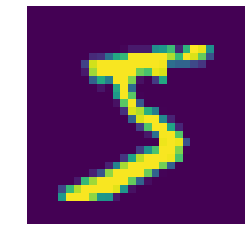

In [9]:
def plot_digit(x):
    plt.imshow(x.reshape((28, 28))) 
    plt.axis('off')
    plt.show()
plot_digit(data[0][0,:])

## DeepLift

In [10]:
# deeplift_analyzer = DeepLIFTCore(model_wo_softmax, reference_inputs=0.0)
deeplift_analyzer = innvestigate.create_analyzer('deep_lift', model_wo_softmax, reference_inputs=0.0)

In [11]:
deeplift_analyzer._model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4719104   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total para

In [12]:
test_data = np.zeros((2, 28, 28, 1))
test_data[0,] = data[0][20,:].reshape((1, 28, 28, 1))

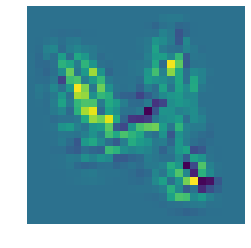

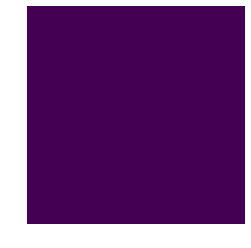

In [13]:
ax = deeplift_analyzer.analyze(test_data)
plot_digit(ax[0])
plot_digit(ax[1])

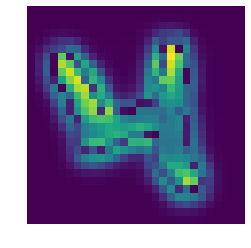

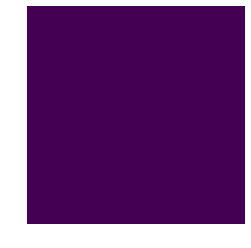

In [14]:
dtd = DeepTaylor(model_wo_softmax)
ax = dtd.analyze(test_data)
plot_digit(ax[0])
plot_digit(ax[1])